# 3. İstatistiksel Analiz

Bu notebook'ta veri setimizin istatistiksel analizlerini gerçekleştireceğiz:
- Hipotez testleri
- Normal dağılım testleri
- T-testleri
- Ki-kare testleri
- ANOVA testleri

## 3.1. Kütüphanelerin İmport Edilmesi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency, ttest_ind, f_oneway
import warnings
warnings.filterwarnings('ignore')

# Ayarlar
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Kütüphaneler yüklendi!")

Kütüphaneler yüklendi!


## 3.2. Veri Setinin Yüklenmesi

In [2]:
df = pd.read_csv('../data/cardio_cleaned.csv')

## 3.3. Temel İstatistiksel Özetler

In [3]:
numeric_cols = [
    'age_years', 'height', 'weight',
    'ap_hi', 'ap_lo', 'bmi', 'pulse_pressure'
]

stats = df[numeric_cols].describe().T
stats['skewness'] = df[numeric_cols].skew()
stats['kurtosis'] = df[numeric_cols].kurtosis()

stats = stats.rename(columns={
    'mean': 'Mean',
    '50%': 'Median',
    'std': 'Std',
    'min': 'Min',
    'max': 'Max',
    '25%': 'Q1',
    '75%': 'Q3'
})

print("SAYISAL DEĞİŞKENLER İÇİN TANIMSAL İSTATİSTİKLER")
display(stats[['Mean', 'Median', 'Std', 'Min', 'Q1', 'Q3', 'Max', 'skewness', 'kurtosis']].round(2))

SAYISAL DEĞİŞKENLER İÇİN TANIMSAL İSTATİSTİKLER


,Mean,Median,Std,Min,Q1,Q3,Max,skewness,kurtosis
age_years,53.33,54.00,6.77,30.00,48.00,58.00,65.00,-0.30,-0.82
height,164.42,165.00,7.90,120.00,159.00,170.00,207.00,0.03,0.57
weight,74.08,72.00,14.20,30.00,65.00,82.00,200.00,0.94,2.03
ap_hi,126.59,120.00,16.47,80.00,120.00,140.00,200.00,0.84,1.28
ap_lo,81.27,80.00,9.33,40.00,80.00,90.00,130.00,0.24,1.19
bmi,27.44,26.35,5.20,10.73,23.88,30.12,59.52,1.17,2.33
pulse_pressure,45.33,40.00,11.55,5.00,40.00,50.00,135.00,1.26,3.20


## 3.4. Normal Dağılım Testleri

In [4]:
# Normal dağılım testleri
from scipy.stats import shapiro, normaltest

results = []

for col in numeric_cols:
    sample = df[col].sample(min(5000, len(df)), random_state=42)

    shapiro_p = shapiro(sample).pvalue
    dagostino_p = normaltest(df[col]).pvalue

    results.append({
        'Özellik': col,
        'Shapiro-Wilk p': shapiro_p,
        'D’Agostino p': dagostino_p,
        'Normal Dağılım': 'Hayır' if shapiro_p < 0.05 else 'Evet'
    })

normality_df = pd.DataFrame(results).round(4)

print("NORMAL DAĞILIM TESTLERİ (p < 0.05 → Normal değil)")
display(normality_df)

NORMAL DAĞILIM TESTLERİ (p < 0.05 → Normal değil)


,Özellik,Shapiro-Wilk p,D’Agostino p,Normal Dağılım
0,age_years,0.0,0.0,Hayır
1,height,0.0,0.0,Hayır
2,weight,0.0,0.0,Hayır
3,ap_hi,0.0,0.0,Hayır
4,ap_lo,0.0,0.0,Hayır
5,bmi,0.0,0.0,Hayır
6,pulse_pressure,0.0,0.0,Hayır


## 3.5. Normal Dağılım Görselleştirmeleri

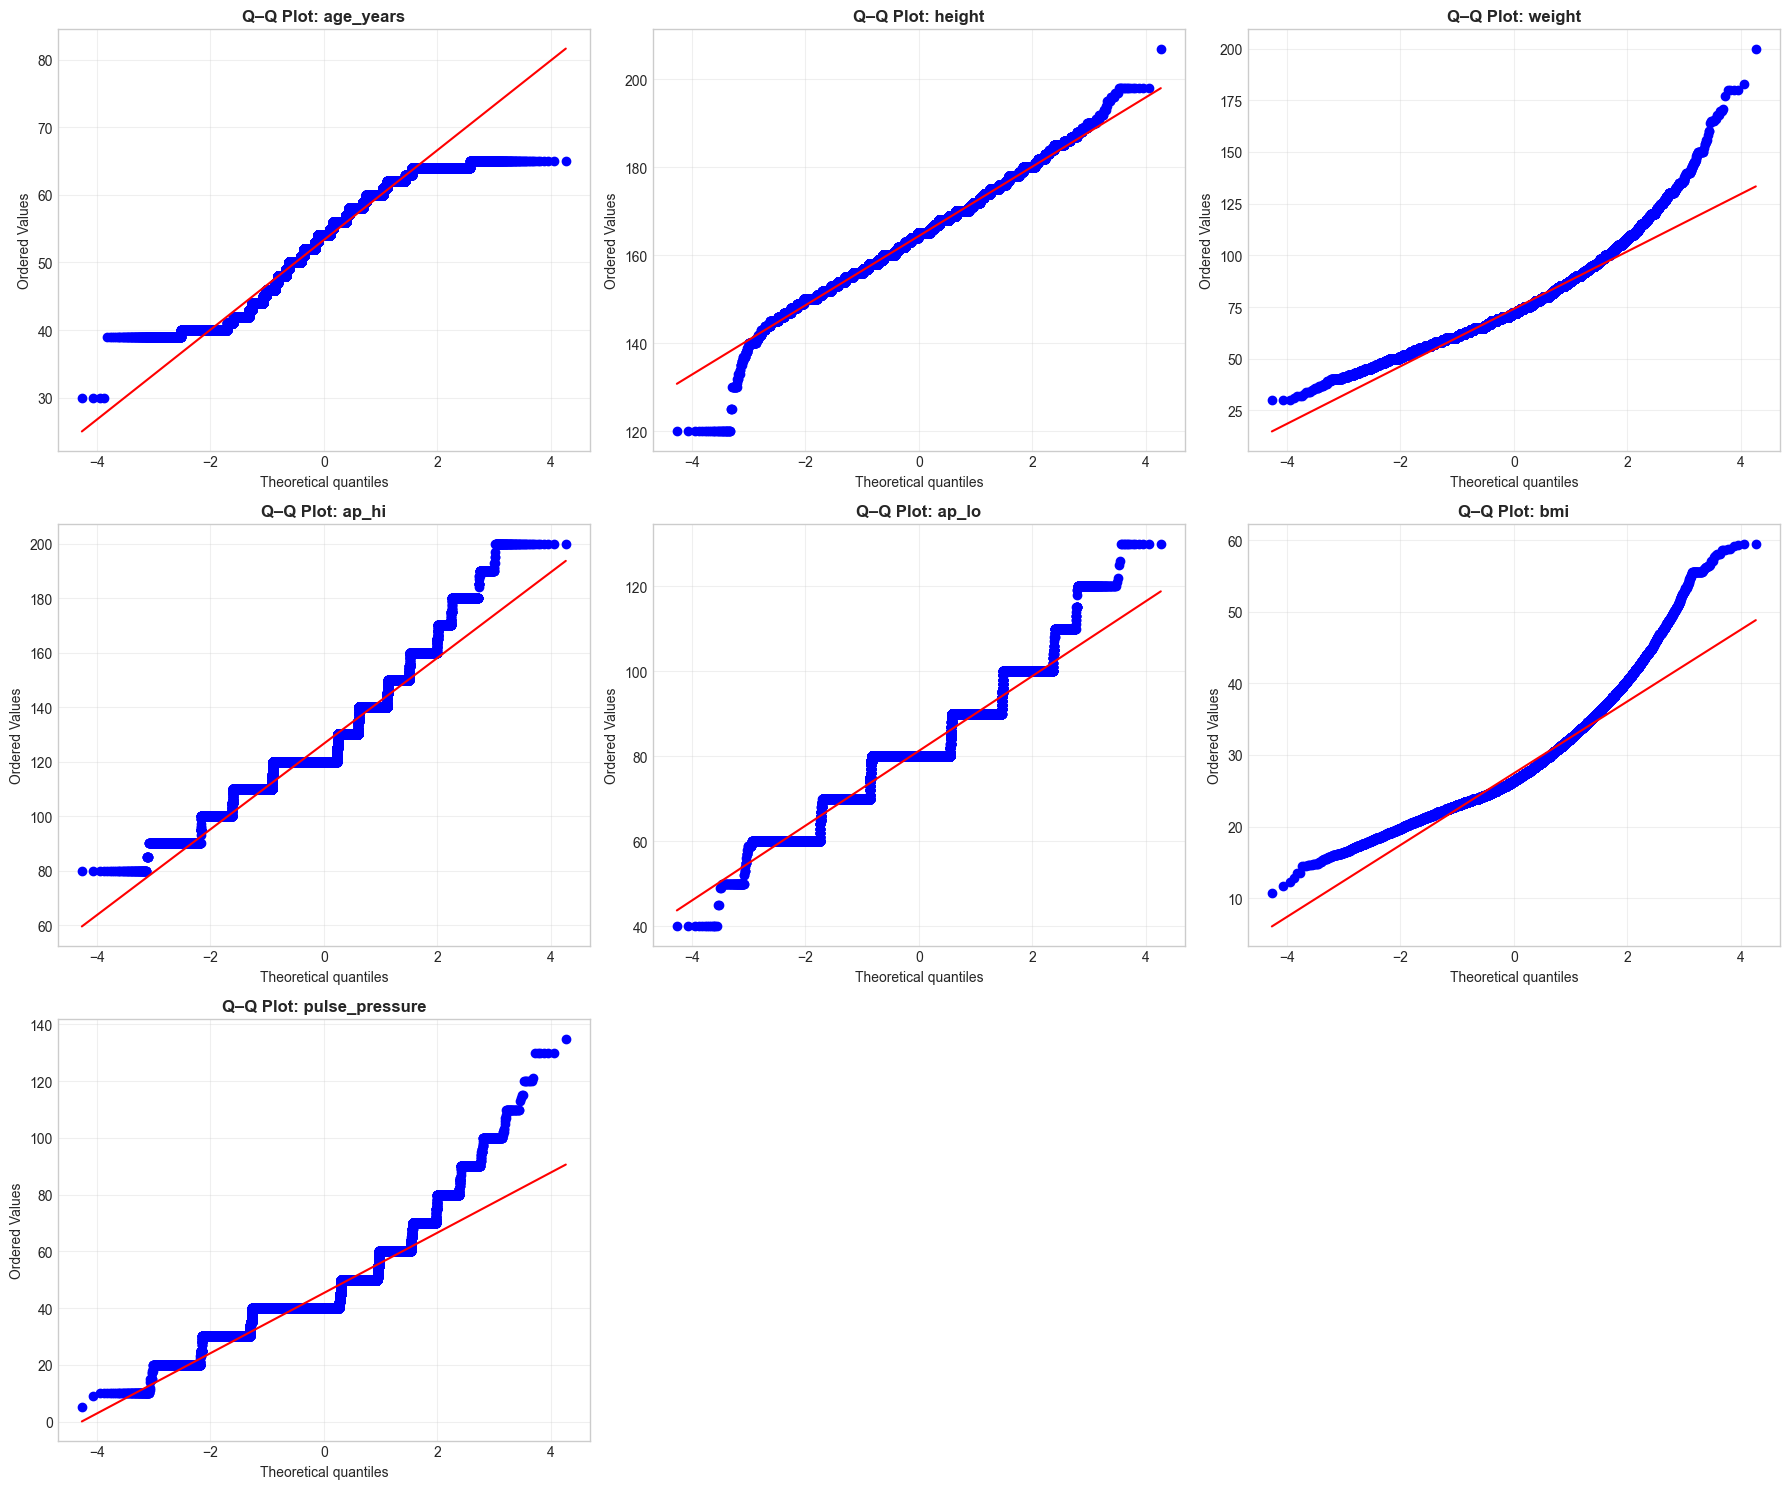

In [5]:
# Q–Q Plotlar
from scipy import stats
import math

n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    stats.probplot(df[col], dist='norm', plot=ax)
    ax.set_title(f'Q–Q Plot: {col}', fontweight='bold')
    ax.grid(alpha=0.3)

# Kullanılmayan eksenleri kaldır
for ax in axes[len(numeric_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


## 3.6. T-Testi: Hasta vs Sağlıklı Gruplar

In [6]:
# Bağımsız İki Örneklem T-Testi (Welch)
from scipy.stats import ttest_ind

healthy = df[df['cardio'] == 0]
sick = df[df['cardio'] == 1]

results = []

for col in numeric_cols:
    t_stat, p_val = ttest_ind(
        healthy[col],
        sick[col],
        equal_var=False  # Welch t-test
    )

    results.append({
        'Özellik': col,
        'Sağlıklı Ortalama': healthy[col].mean(),
        'Hasta Ortalama': sick[col].mean(),
        'Ortalama Farkı (Hasta - Sağlıklı)': sick[col].mean() - healthy[col].mean(),
        't-istatistiği': t_stat,
        'p-değeri': p_val,
        'Anlamlı (p < 0.05)': 'Evet' if p_val < 0.05 else 'Hayır'
    })

ttest_df = pd.DataFrame(results).round(4)

print("BAĞIMSIZ İKİ ÖRNEKLEM T-TESTİ (Welch)")
print("=" * 60)
display(ttest_df)


BAĞIMSIZ İKİ ÖRNEKLEM T-TESTİ (Welch)


,Özellik,Sağlıklı Ortalama,Hasta Ortalama,Ortalama Farkı (Hasta - Sağlıklı),t-istatistiği,p-değeri,Anlamlı (p < 0.05)
0,age_years,51.7255,54.9620,3.2366,-64.5070,0.0000,Evet
1,height,164.5085,164.3201,-0.1884,3.1186,0.0018,Evet
2,weight,71.5366,76.6739,5.1373,-48.0746,0.0000,Evet
3,ap_hi,119.5781,133.7655,14.1874,-124.5273,0.0000,Evet
4,ap_lo,78.1165,84.4885,6.3720,-94.8812,0.0000,Evet
5,bmi,26.4582,28.4449,1.9867,-50.9159,0.0000,Evet
6,pulse_pressure,41.4616,49.2771,7.8154,-93.7070,0.0000,Evet


In [7]:
# Anlamlı fark bulunan özellikler
significant_features = ttest_df.loc[
    ttest_df['Anlamlı (p < 0.05)'] == 'Evet', 'Özellik'
].tolist()

print(f"Anlamlı fark bulunan özellikler: {len(significant_features)}/{len(numeric_cols)}")
print("-" * 50)
for f in significant_features:
    print(f"• {f}")

Anlamlı fark bulunan özellikler: 7/7
--------------------------------------------------
• age_years
• height
• weight
• ap_hi
• ap_lo
• bmi
• pulse_pressure


## 3.7. Ki-Kare Testi: Kategorik Değişkenler

In [9]:
# Ki-Kare Bağımsızlık Testi
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['cardio'])

    chi2, p_val, dof, expected = chi2_contingency(contingency_table)

    # Cramér's V (etki büyüklüğü)
    n = contingency_table.to_numpy().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))

    # Etki yorumu
    if cramers_v >= 0.25:
        effect = 'Güçlü'
    elif cramers_v >= 0.10:
        effect = 'Orta'
    else:
        effect = 'Zayıf'

    results.append({
        'Özellik': feature,
        'Ki-Kare (χ²)': chi2,
        'Serbestlik Derecesi': dof,
        'p-değeri': p_val,
        "Cramér's V": cramers_v,
        'Anlamlı (p < 0.05)': 'Evet' if p_val < 0.05 else 'Hayır',
        'Etki Düzeyi': effect
    })

chi2_df = pd.DataFrame(results).round(4)

print("Kİ-KARE BAĞIMSIZLIK TESTİ SONUÇLARI")
display(chi2_df)


Kİ-KARE BAĞIMSIZLIK TESTİ SONUÇLARI


,Özellik,Ki-Kare (χ²),Serbestlik Derecesi,p-değeri,Cramér's V,Anlamlı (p < 0.05),Etki Düzeyi
0,gender,3.3891,1,0.0656,0.0070,Hayır,Zayıf
1,cholesterol,3358.2525,2,0.0000,0.2214,Evet,Orta
2,gluc,575.5287,2,0.0000,0.0916,Evet,Zayıf
3,smoke,18.4977,1,0.0000,0.0164,Evet,Zayıf
4,alco,4.8287,1,0.0280,0.0084,Evet,Zayıf
5,active,97.7063,1,0.0000,0.0378,Evet,Zayıf


Ki-kare bağımsızlık testi sonuçlarına göre bazı kategorik değişkenler ile kardiyovasküler hastalık durumu arasında istatistiksel olarak anlamlı ilişkiler tespit edilmiştir (p < 0.05). Etki büyüklükleri Cramér’s V ile değerlendirilmiş ve değişkenlerin hastalık durumu üzerindeki etkileri zayıf–orta–güçlü düzeylerde sınıflandırılmıştır.

## 3.8. ANOVA Testi: Çoklu Grup Karşılaştırmaları

TEK YÖNLÜ ANOVA (ONE-WAY ANOVA) TESTİ
Amaç: Üç veya daha fazla grubun ortalamaları arasında istatistiksel olarak
anlamlı bir fark olup olmadığını incelemek.

H0: Tüm grupların ortalamaları eşittir.
H1: En az bir grubun ortalaması diğerlerinden farklıdır.

Karar Kuralı: p-değeri < 0.05 ise H0 reddedilir.

In [13]:
# Tek Yönlü ANOVA: Kolesterol Seviyelerine Göre Yaş
cholesterol_labels = {1: 'Normal', 2: 'Yüksek', 3: 'Çok Yüksek'}

chol_groups = [
    df[df['cholesterol'] == level]['age_years']
    for level in cholesterol_labels.keys()
]

f_stat, p_val = f_oneway(*chol_groups)

print("\n Kolesterol Seviyelerine Göre Yaş Analizi")
print(f"F-istatistiği : {f_stat:.4f}")
print(f"p-değeri      : {p_val:.6f}")
print("Sonuç         :", "Anlamlı fark var" if p_val < 0.05 else "Anlamlı fark yok")

for level, label in cholesterol_labels.items():
    mean_age = df[df['cholesterol'] == level]['age_years'].mean()
    print(f"  {label:<12}: Ortalama yaş = {mean_age:.2f}")



 Kolesterol Seviyelerine Göre Yaş Analizi
F-istatistiği : 898.7381
p-değeri      : 0.000000
Sonuç         : Anlamlı fark var
  Normal      : Ortalama yaş = 52.82
  Yüksek      : Ortalama yaş = 53.70
  Çok Yüksek  : Ortalama yaş = 56.22


In [14]:
# Tek Yönlü ANOVA: Glukoz Seviyelerine Göre Yaş
glucose_labels = {1: 'Normal', 2: 'Yüksek', 3: 'Çok Yüksek'}

gluc_groups = [
    df[df['gluc'] == level]['age_years']
    for level in glucose_labels.keys()
]

f_stat, p_val = f_oneway(*gluc_groups)

print("\n Glukoz Seviyelerine Göre Yaş Analizi")

print(f"F-istatistiği : {f_stat:.4f}")
print(f"p-değeri      : {p_val:.6f}")
print("Sonuç         :", "Anlamlı fark var" if p_val < 0.05 else "Anlamlı fark yok")
for level, label in glucose_labels.items():
    mean_age = df[df['gluc'] == level]['age_years'].mean()
    print(f"  {label:<12}: Ortalama yaş = {mean_age:.2f}")



 Glukoz Seviyelerine Göre Yaş Analizi
F-istatistiği : 344.3987
p-değeri      : 0.000000
Sonuç         : Anlamlı fark var
  Normal      : Ortalama yaş = 53.08
  Yüksek      : Ortalama yaş = 53.92
  Çok Yüksek  : Ortalama yaş = 55.55


In [20]:
# Tek Yönlü ANOVA: BMI Kategorilerine Göre Sistolik Kan Basıncı
bmi_order = ['Zayıf', 'Normal', 'Fazla Kilolu', 'Obez']

bmi_groups = [
    df[df['bmi_category'] == category]['ap_hi']
    for category in bmi_order
    if len(df[df['bmi_category'] == category]) > 0
]

print("\n BMI Kategorilerine Göre Sistolik Kan Basıncı Analizi")

if len(bmi_groups) > 1:
    f_stat, p_val = f_oneway(*bmi_groups)

    print(f"F-istatistiği : {f_stat:.4f}")
    print(f"p-değeri      : {p_val:.6f}")
    print("Sonuç         :", "Anlamlı fark var" if p_val < 0.05 else "Anlamlı fark yok")

    for category in bmi_order:
        subset = df[df['bmi_category'] == category]
        if not subset.empty:
            print(f"  {category:<12}: Ortalama SBP = {subset['ap_hi'].mean():.2f}")



 BMI Kategorilerine Göre Sistolik Kan Basıncı Analizi
F-istatistiği : 1568.3460
p-değeri      : 0.000000
Sonuç         : Anlamlı fark var
  Zayıf       : Ortalama SBP = 115.54
  Normal      : Ortalama SBP = 122.32
  Fazla Kilolu: Ortalama SBP = 126.87
  Obez        : Ortalama SBP = 132.64


## 3.9. Korelasyon Anlamlılık Testleri

In [22]:
# Korelasyon Anlamlılık Testleri: Pearson ve Spearman
from scipy.stats import pearsonr, spearmanr

print("\nKORELASYON ANLAMLILIK TESTLERİ")
print("Amaç: Sayısal özellikler ile hedef değişken (cardio) arasındaki")
print("doğrusal (Pearson) ve sıralı (Spearman) korelasyonları incelemek.")
print("\nAnlamlılık Kriteri: p-değeri < 0.05")

correlation_results = []

for feature in numeric_cols:
    # Pearson Korelasyonu (doğrusal ilişki)
    pearson_r, pearson_p = pearsonr(df[feature], df['cardio'])
    
    # Spearman Korelasyonu (monotonik ilişki)
    spearman_rho, spearman_p = spearmanr(df[feature], df['cardio'])

    correlation_results.append({
        'Özellik': feature,
        'Pearson r': f"{pearson_r:.4f}",
        'Pearson p-değeri': f"{pearson_p:.6f}",
        'Spearman ρ': f"{spearman_rho:.4f}",
        'Spearman p-değeri': f"{spearman_p:.6f}",
        'Anlamlılık (Pearson)': '✓ Evet' if pearson_p < 0.05 else '✗ Hayır'
    })

# Sonuçları DataFrame'e çevir ve korelasyona göre sırala
corr_test_df = (
    pd.DataFrame(correlation_results)
    .sort_values(by='Pearson r', ascending=False)
)

print(corr_test_df.to_string(index=False))


KORELASYON ANLAMLILIK TESTLERİ
Amaç: Sayısal özellikler ile hedef değişken (cardio) arasındaki
doğrusal (Pearson) ve sıralı (Spearman) korelasyonları incelemek.

Anlamlılık Kriteri: p-değeri < 0.05
       Özellik Pearson r Pearson p-değeri Spearman ρ Spearman p-değeri Anlamlılık (Pearson)
         ap_hi    0.4308         0.000000     0.4516          0.000000               ✓ Evet
         ap_lo    0.3413         0.000000     0.3562          0.000000               ✓ Evet
pulse_pressure    0.3382         0.000000     0.3575          0.000000               ✓ Evet
     age_years    0.2391         0.000000     0.2369          0.000000               ✓ Evet
           bmi    0.1912         0.000000     0.1972          0.000000               ✓ Evet
        weight    0.1809         0.000000     0.1804          0.000000               ✓ Evet
        height   -0.0119         0.001813    -0.0125          0.001101               ✓ Evet


In [24]:
print("KORELASYON KATSAYISI YORUMLAMA REHBERİ")
print("  |r| = 0.00 – 0.10  → Çok zayıf ilişki")
print("  |r| = 0.10 – 0.30  → Zayıf ilişki")
print("  |r| = 0.30 – 0.50  → Orta düzey ilişki")
print("  |r| = 0.50 – 0.70  → Güçlü ilişki")
print("  |r| = 0.70 – 1.00  → Çok güçlü ilişki")

KORELASYON KATSAYISI YORUMLAMA REHBERİ
  |r| = 0.00 – 0.10  → Çok zayıf ilişki
  |r| = 0.10 – 0.30  → Zayıf ilişki
  |r| = 0.30 – 0.50  → Orta düzey ilişki
  |r| = 0.50 – 0.70  → Güçlü ilişki
  |r| = 0.70 – 1.00  → Çok güçlü ilişki


Pearson ve Spearman korelasyon analizleri kullanılarak, sayısal değişkenler ile kardiyovasküler hastalık durumu arasındaki ilişkiler incelenmiştir. Pearson korelasyonu doğrusal ilişkileri değerlendirirken, Spearman korelasyonu değişkenler arasındaki monotonik ilişkileri ortaya koymaktadır. İstatistiksel anlamlılık düzeyi α = 0.05 olarak belirlenmiştir.